# LAB 4: Attention

Assignment made by:

Alessandro Viviani 843234

Francesca Arredondo 820354

Fabio Turchetta 898572


# Introduction:
Each of us designed a different architecture for the NeuMF model with attention. All three are similar in performances. We show the coding part of only one of them (Viviani's), while for the others we show just the general structure followed by some comments.

In [ ]:
import os
import time
import random
import argparse
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt 
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [ ]:
np.random.seed(55)
torch.manual_seed(5)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cpu")

In [ ]:
dataset_origin = {'100k': 'u.data', '1M': 'ratings.dat'}

num_sample_data = '100k'
DATA_PATH = 'drive/MyDrive/Colab Notebooks/ml-100k/u.data'.format(dataset_origin[num_sample_data]) 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Class Rating_Dataset

In [ ]:
#@title
class Rating_Datset(Dataset):
	def __init__(self, user_list, item_list, rating_list):
		super(Rating_Datset, self).__init__()
		self.user_list = user_list
		self.item_list = item_list
		self.rating_list = rating_list

	def __len__(self):
		return len(self.user_list)

	def __getitem__(self, idx):
		user = self.user_list[idx]
		item = self.item_list[idx]
		rating = self.rating_list[idx]
		
		return (
			torch.tensor(user, dtype=torch.long),
			torch.tensor(item, dtype=torch.long),
			torch.tensor(rating, dtype=torch.float)
			)

Class NCF_Data

In [ ]:
#@title
class NCF_Data(object):
	"""
	Construct Dataset for NCF
	"""
	def __init__(self, args, ratings):
		self.ratings = ratings
		self.num_ng = args.num_ng
		self.num_ng_test = args.num_ng_test
		self.batch_size = args.batch_size

		self.preprocess_ratings = self._reindex(self.ratings)

		self.user_pool = set(self.ratings['user_id'].unique())
		self.item_pool = set(self.ratings['item_id'].unique())

		self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings)
		self.negatives = self._negative_sampling(self.preprocess_ratings)

	
	def _reindex(self, ratings):
		"""
		Process dataset to reindex userID and itemID, also set rating as binary feedback
		"""
		user_list = list(ratings['user_id'].drop_duplicates())
		user2id = {w: i for i, w in enumerate(user_list)}

		item_list = list(ratings['item_id'].drop_duplicates())
		item2id = {w: i for i, w in enumerate(item_list)}

		ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
		ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])
		ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))
		return ratings

	def _leave_one_out(self, ratings):
		"""
		leave-one-out evaluation protocol in paper https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf
		"""
		ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
		test = ratings.loc[ratings['rank_latest'] == 1]
		train = ratings.loc[ratings['rank_latest'] > 1]
		assert train['user_id'].nunique()==test['user_id'].nunique(), 'Not Match Train User with Test User'
		return train[['user_id', 'item_id', 'rating']], test[['user_id', 'item_id', 'rating']]

	def _negative_sampling(self, ratings):
		interact_status = (
			ratings.groupby('user_id')['item_id']
			.apply(set)
			.reset_index()
			.rename(columns={'item_id': 'interacted_items'}))
		interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
		interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
		return interact_status[['user_id', 'negative_items', 'negative_samples']]

	def get_train_instance(self):
		users, items, ratings = [], [], []
		train_ratings = pd.merge(self.train_ratings, self.negatives[['user_id', 'negative_items']], on='user_id')
		train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
		for row in train_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in range(self.num_ng):
				users.append(int(row.user_id))
				items.append(int(row.negatives[i]))
				ratings.append(float(0))  # negative samples get 0 rating
		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

	def get_test_instance(self):
		users, items, ratings = [], [], []
		test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')
		for row in test_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in getattr(row, 'negative_samples'):
				users.append(int(row.user_id))
				items.append(int(i))
				ratings.append(float(0))
		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.num_ng_test+1, shuffle=False, num_workers=2)

Metrics

In [ ]:
#@title
def hit(ng_item, pred_items):
	if ng_item in pred_items:
		return 1
	return 0


def ndcg(ng_item, pred_items):
	if ng_item in pred_items:
		index = pred_items.index(ng_item)
		return np.reciprocal(np.log2(index+2))
	return 0


def metrics(model, test_loader, top_k, device):
	HR, NDCG = [], []

	for user, item, label in test_loader:
		user = user.to(device)
		item = item.to(device)

		predictions = model(user, item)
		_, indices = torch.topk(predictions, top_k)
		recommends = torch.take(
				item, indices).cpu().numpy().tolist()

		ng_item = item[0].item() # leave one-out evaluation has only one item per user
		HR.append(hit(ng_item, recommends))
		NDCG.append(ndcg(ng_item, recommends))

	return np.mean(HR), np.mean(NDCG)
 

def plot_metrics(title, metric, list1, list2, list3, list4):
	plt.title(title)
	plt.xlabel('Epochs')
	plt.ylabel(metric)
	x = list(range(1,len(list1)+1))
	plt.plot(x, list1, 'bo-', label='NeuMF_Viviani')
	plt.plot(x, list2, 'go-', label='NeuMF_Turchetta')
	plt.plot(x, list3, 'ro-', label='NeuMF_Arredondo')
	plt.plot(x, list4, 'yo-', label='NeuMF_original')
	plt.legend()
	plt.show()

	return 0

# Attention Layer and Transformer
From the given attention class we modified it to pass batches one at a time of size 256. We used multihead with 8 heads.
The attention layer is used inside the transformer together with normalization layers, dropout layers and two fully connected layers.

In [ ]:
class MHSelfAttention(nn.Module):
    """
    Multi-head self attention.
    """

    def __init__(self, emb, heads=8):
        """
        :param emb:
        :param heads:
        :param mask:
        """
        super().__init__()
        
        assert emb % heads == 0, f'Embedding dimension ({emb}) should be divisible by nr. of heads ({heads})'

        self.emb = emb
        self.heads = heads

        #s = emb // heads
        # - We will break the embedding into `heads` chunks and feed each to a different attention head

        self.tokeys    = nn.Linear(emb, emb, bias=False)
        self.toqueries = nn.Linear(emb, emb, bias=False)
        self.tovalues  = nn.Linear(emb, emb, bias=False)

        self.unifyheads = nn.Linear(emb, emb)

    def forward(self, x):

        b, e = x.size()
        h = self.heads
        assert e == self.emb, f'Input embedding dim ({e}) should match layer embedding dim ({self.emb})'

        s = e // h

        # We first compute the k/q/v's on the whole embedding vectors, and then split into the different heads.

        keys    = self.tokeys(x)
        queries = self.toqueries(x)
        values  = self.tovalues(x)

        # Split into the different heads.

        keys    = keys.view(b, 1, h, s)
        queries = queries.view(b, 1, h, s)
        values  = values.view(b, 1, h, s)

        # Compute scaled dot-product self-attention

        # Fold heads into the batch dimension
        # When you call contiguous(), it actually makes a copy of the tensor 
        # such that the order of its elements in memory is the same as if it had been created from scratch with the same data.
        keys = keys.transpose(1, 2).contiguous().view(b * h, 1, s)
        queries = queries.transpose(1, 2).contiguous().view(b * h, 1, s)
        values = values.transpose(1, 2).contiguous().view(b * h, 1, s)

        queries = queries / (e ** (1/4))
        keys    = keys / (e ** (1/4))
        # Instead of dividing the dot products by sqrt(e), we scale the keys and values.
        # This should be more memory efficient

        # Get dot product of queries and keys, and scale.

        dot = torch.bmm(queries, keys.transpose(1, 2))

        assert dot.size() == (b * h, 1, 1)

        dot = F.softmax(dot, dim=2) # Dot now has row-wise self-attention probabilities

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, 1, s)

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, 1, s * h)

        return self.unifyheads(out)



class TransformerBlock(nn.Module):

    def __init__(self, emb, heads=8, mask=False, seq_length=64, ff_hidden_mult=4, dropout=0.0, pos_embedding=None):
        super().__init__()

        self.mhattention = MHSelfAttention(emb, heads)

        self.norm1 = nn.LayerNorm(emb)
        self.norm2 = nn.LayerNorm(emb)

        self.ff = nn.Sequential(
            nn.Linear(emb, ff_hidden_mult * emb),
            nn.Linear(ff_hidden_mult * emb, emb)
        )

        self.do = nn.Dropout(dropout)

    def forward(self, x):

        attended = self.mhattention(x)
        attended = attended.squeeze()

        x = self.norm1(attended + x) #residual
      
        x = self.do(x)

        fedforward = self.ff(x)

        x = self.norm2(fedforward + x) #residual

        x = self.do(x)

        return x


# The NeuMF model with attention:
The architecture follows the paper: "Deep Collaborative Recommendation Algorithm Based on Attention Mechanism" by Can Cui published in 2022. 

GMF Branch: before the element-wise product, each embedding is passed to a multi-head self attention layer which adaptively assigns different weights to the user-item representations and gives more importance to some features rather than others. Then they are passed to a transformer module which further elaborates them.

MLP Branch: after the concatenation of the embeddings, the resulting embedding is passed to a attention layer and the transformer. Again this procedure should enhance the important features of the representation.

NeuMF Branch: like in the original NeuMF model, the GMF and MLP layers are concatenated and passed to a sigmoid function to get the score.

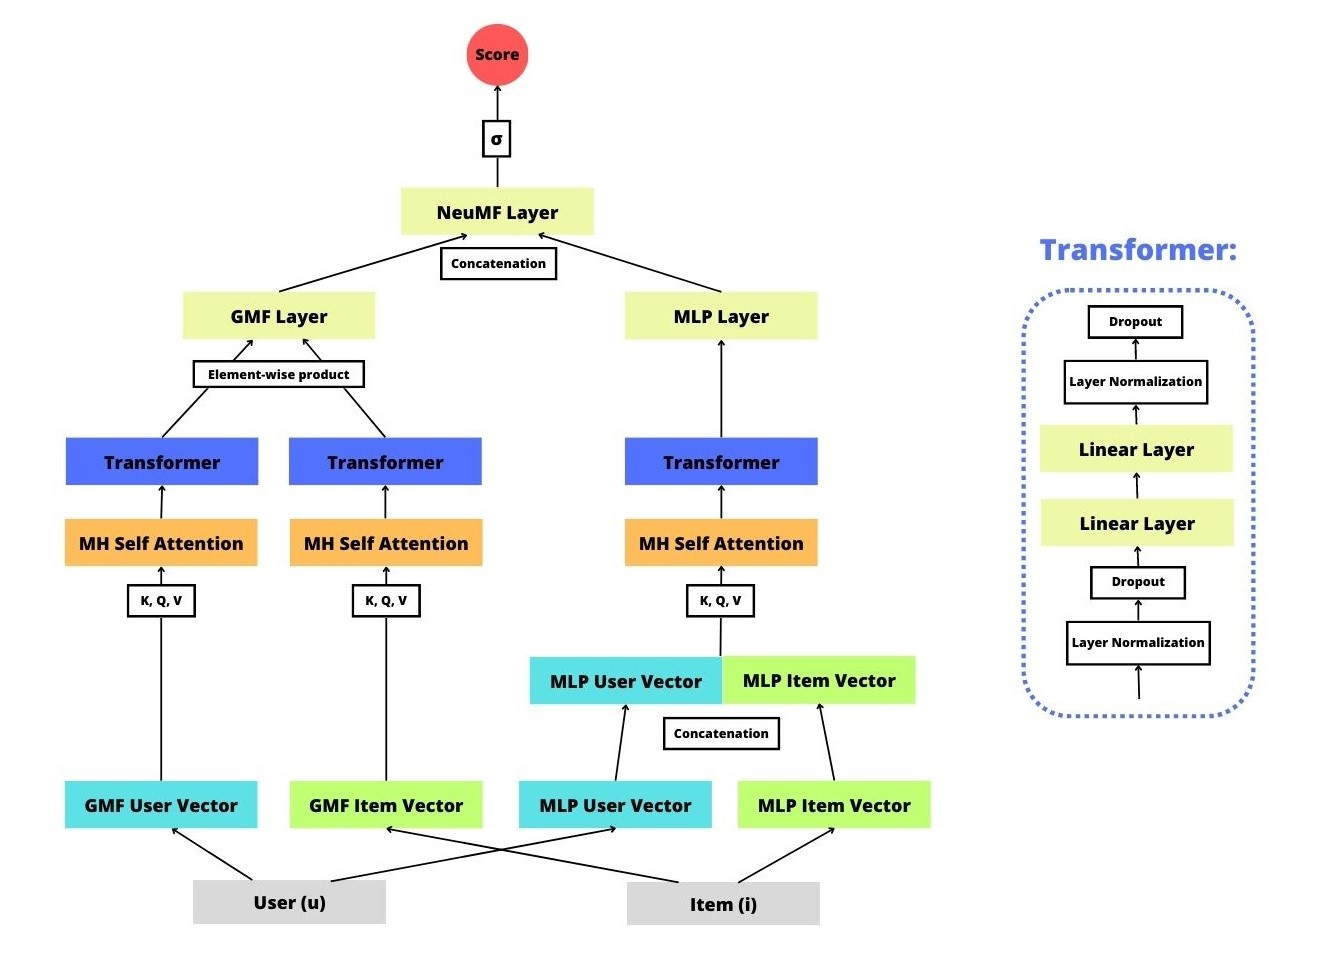

In [ ]:
class NeuMF_Viviani(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(NeuMF_Viviani, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num
        self.layers = args.layers

        self.gmf_user_embedding = nn.Embedding(self.num_users, self.factor_num)
        self.gmf_item_embedding = nn.Embedding(self.num_items, self.factor_num)
        self.mlp_user_embedding = nn.Embedding(self.num_users, self.factor_num)
        self.mlp_item_embedding = nn.Embedding(self.num_items, self.factor_num)

        mlp_layer_sizes = self.layers
        self.mlp_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(mlp_layer_sizes[:-1], mlp_layer_sizes[1:])):
            self.mlp_layers.append(nn.Linear(in_size, out_size))

        self.transformer = TransformerBlock(emb=self.factor_num, heads=8, mask=False, seq_length=64, ff_hidden_mult=4, dropout=0.0, pos_embedding=None)
        self.transformer2 = TransformerBlock(emb=self.factor_num*2, heads=8, mask=False, seq_length=64, ff_hidden_mult=4, dropout=0.0, pos_embedding=None)

        self.output_layer = nn.Linear(self.factor_num + int(self.factor_num/4), out_features=1)
        self.logistic = torch.sigmoid

    def forward(self, user_indices, item_indices):
        # Matrix factorization branch
        gmf_user_embedding = self.gmf_user_embedding(user_indices) # 256 x 32
        gmf_user_embedding = self.transformer(gmf_user_embedding) # 256 x 32
        gmf_item_embedding = self.gmf_item_embedding(item_indices)
        gmf_item_embedding = self.transformer(gmf_item_embedding)
        gmf_output = torch.mul(gmf_user_embedding, gmf_item_embedding) # GMF layer

        # Multilayer perceptron branch
        mlp_user_embedding = self.mlp_user_embedding(user_indices)
        mlp_item_embedding = self.mlp_item_embedding(item_indices)
        mlp_output = torch.cat([mlp_user_embedding, mlp_item_embedding], dim=1)
        mlp_output = self.transformer2(mlp_output)

        for idx, _ in enumerate(range(len(self.mlp_layers))):
            mlp_output = self.mlp_layers[idx](mlp_output)
            mlp_output = nn.ReLU()(mlp_output)

        # Concatenate GMF, MLP and Transformer Outputs and pass through final layer
        concatenated = torch.cat([gmf_output, mlp_output], dim=1) # [256, 40]
        logits = self.output_layer(concatenated)
        rating = self.logistic(logits)
        return rating.squeeze()

Argument Parser:

In [ ]:
#@title
#collapse-hide
parser = argparse.ArgumentParser()
parser.add_argument("--seed", 
	type=int, 
	default=51, 
	help="Seed")
parser.add_argument("--lr", 
	type=float, 
	default=0.001, 
	help="learning rate")
parser.add_argument("--dropout", 
	type=float,
	default=0.2,  
	help="dropout rate")
parser.add_argument("--batch_size", 
	type=int, 
	default=256, 
	help="batch size for training")
parser.add_argument("--epochs", 
	type=int,
	default=30,  
	help="training epoches")
parser.add_argument("--top_k", 
	type=int, 
	default=10, 
	help="compute metrics@top_k")
parser.add_argument("--factor_num", 
	type=int,
	default=32, 
	help="predictive factors numbers in the model")
parser.add_argument("--layers",
    nargs='+', 
    default=[64,32,16,8],
    help="MLP layers. Note that the first layer is the concatenation of user \
    and item embeddings. So layers[0]/2 is the embedding size.")
parser.add_argument("--num_ng", 
	type=int,
	default=4, 
	help="Number of negative samples for training set")
parser.add_argument("--num_ng_test", 
	type=int,
	default=100, 
	help="Number of negative samples for test set")
parser.add_argument("--out", 
	default=True,
	help="save model or not")
parser.add_argument("--hidden_dim", 
	type=int, 
	default=64, 
	)

_StoreAction(option_strings=['--hidden_dim'], dest='hidden_dim', nargs=None, const=None, default=64, type=<class 'int'>, choices=None, required=False, help=None, metavar=None)

# Main

In [ ]:
 # set device and parameters
args = parser.parse_args("")
device = torch.device("cpu")

# load data
ml_100k = pd.read_csv(
	DATA_PATH, 
	sep="\t", 
	names = ['user_id', 'item_id', 'rating', 'timestamp'], 
	engine='python')

# set the num_users, items
num_users = ml_100k['user_id'].nunique()+1
num_items = ml_100k['item_id'].nunique()+1

# construct the train and test datasets
data = NCF_Data(args, ml_100k)
train_loader = data.get_train_instance()
test_loader = data.get_test_instance()

<ipython-input-22-fa01be874ac8>:53: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
<ipython-input-22-fa01be874ac8>:59: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warn

In [ ]:
# set model and loss, optimizer
model = NeuMF_Viviani(args, num_users, num_items)
model = model.to(device)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

# initialize lists for plots (the other models were trained separately and here we report their performances)
NeuMF_Viviani_HR_epochs = []
NeuMF_Turchetta_HR_epochs = [0.408, 0.402, 0.417, 0.44, 0.474, 0.505, 0.515, 0.525, 0.534, 0.55, 0.566, 0.559, 0.561, 0.567, 0.572, 0.575, 0.568, 0.572, 0.579, 0.578, 0.578, 0.589, 0.587, 0.581, 0.58, 0.594, 0.589, 0.59, 0.592, 0.593]
NeuMF_Arredondo_HR_epochs = [0.400, 0.414, 0.397, 0.438, 0.453, 0.510, 0.531, 0.542, 0.561, 0.562, 0.577, 0.580, 0.584, 0.569, 0.591, 0.601, 0.595, 0.579, 0.583, 0.590, 0.583, 0.583, 0.575, 0.594, 0.574, 0.586, 0.589, 0.580, 0.565, 0.586]
NeuMF_original_HR_epochs = [0.398, 0.404, 0.413, 0.408, 0.415, 0.439, 0.446, 0.472, 0.469, 0.483, 0.498, 0.498, 0.514, 0.529, 0.527, 0.525, 0.53, 0.542, 0.546, 0.542, 0.547, 0.556, 0.555, 0.573, 0.561, 0.575, 0.577, 0.569, 0.562, 0.567]
NeuMF_Viviani_NDCG_epochs = []
NeuMF_Turchetta_NDCG_epochs = [0.212, 0.221, 0.228, 0.245, 0.267, 0.281, 0.291, 0.298, 0.305, 0.311, 0.315, 0.314, 0.316, 0.316, 0.319, 0.32, 0.317, 0.32, 0.32, 0.319, 0.318, 0.325, 0.325, 0.321, 0.323, 0.328, 0.325, 0.327, 0.325, 0.326]
NeuMF_Arredondo_NDCG_epochs = [0.22, 0.221, 0.217, 0.235, 0.25, 0.273, 0.29, 0.303, 0.312, 0.311, 0.321, 0.322, 0.321, 0.319, 0.329, 0.337, 0.333, 0.327, 0.327, 0.33, 0.327, 0.326, 0.324, 0.33, 0.319, 0.327, 0.324, 0.316, 0.311, 0.318]
NeuMF_original_NDCG_epochs = [0.21, 0.223, 0.22, 0.218, 0.227, 0.232, 0.239, 0.255, 0.258, 0.266, 0.272, 0.276, 0.285, 0.29, 0.297, 0.296, 0.302, 0.306, 0.306, 0.304, 0.311, 0.315, 0.317, 0.321, 0.317, 0.323, 0.322, 0.317, 0.319, 0.321]


In [ ]:
# train, evaluation
best_hr = 0
for epoch in range(1, args.epochs+1):
	model.train() # Enable dropout (if have).
	start_time = time.time()

	for user, item, label in train_loader:
		user = user.to(device)
		item = item.to(device)
		label = label.to(device)

		optimizer.zero_grad()
		prediction = model(user, item)
		loss = loss_function(prediction, label)
		loss.backward()
		optimizer.step()

	model.eval()
	HR, NDCG = metrics(model, test_loader, args.top_k, device)

	elapsed_time = time.time() - start_time
	print("Epoch {:03d}".format(epoch) + " time to train: " + 
			time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
	print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

	# fill lists for plots
	NeuMF_Viviani_HR_epochs.append(HR)
	NeuMF_Viviani_NDCG_epochs.append(NDCG)
			

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 001 time to train: 00: 00: 40
HR: 0.405	NDCG: 0.218
Epoch 002 time to train: 00: 00: 43
HR: 0.401	NDCG: 0.217
Epoch 003 time to train: 00: 00: 41
HR: 0.414	NDCG: 0.222
Epoch 004 time to train: 00: 00: 39
HR: 0.399	NDCG: 0.220
Epoch 005 time to train: 00: 00: 40
HR: 0.449	NDCG: 0.252
Epoch 006 time to train: 00: 00: 40
HR: 0.494	NDCG: 0.276
Epoch 007 time to train: 00: 00: 38
HR: 0.509	NDCG: 0.280
Epoch 008 time to train: 00: 00: 39
HR: 0.526	NDCG: 0.287
Epoch 009 time to train: 00: 00: 41
HR: 0.540	NDCG: 0.293
Epoch 010 time to train: 00: 00: 50
HR: 0.545	NDCG: 0.297
Epoch 011 time to train: 00: 00: 48
HR: 0.542	NDCG: 0.297
Epoch 012 time to train: 00: 00: 42
HR: 0.544	NDCG: 0.300
Epoch 013 time to train: 00: 00: 43
HR: 0.566	NDCG: 0.313
Epoch 014 time to train: 00: 00: 45
HR: 0.567	NDCG: 0.318
Epoch 015 time to train: 00: 00: 52
HR: 0.561	NDCG: 0.312
Epoch 016 time to train: 00: 00: 44
HR: 0.577	NDCG: 0.314
Epoch 017 time to train: 00: 00: 44
HR: 0.574	NDCG: 0.314
Epoch 018 time

Plot

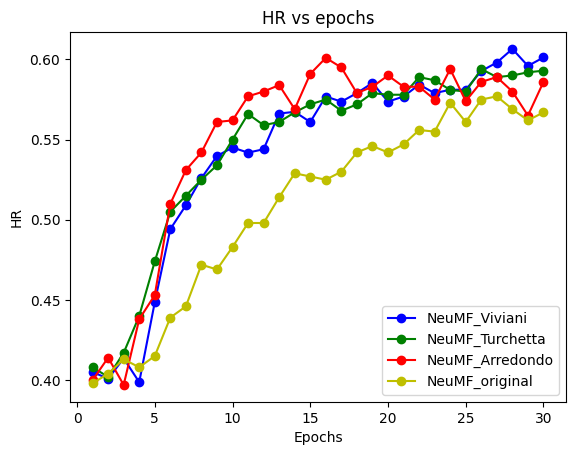

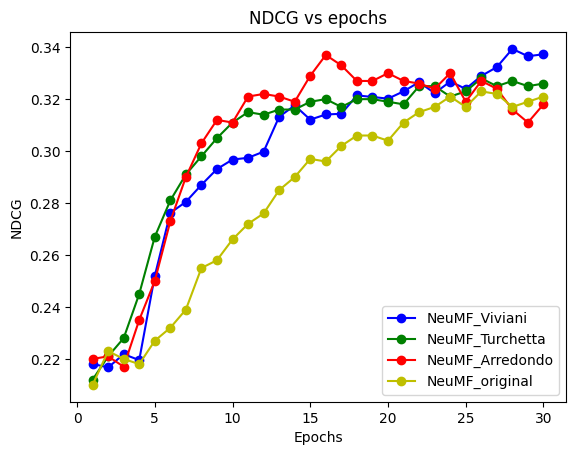

0

In [ ]:
# Compute and show plots of metrics:
plot_metrics("HR vs epochs", "HR", NeuMF_Viviani_HR_epochs, NeuMF_Turchetta_HR_epochs, NeuMF_Arredondo_HR_epochs, NeuMF_original_HR_epochs)
plot_metrics("NDCG vs epochs", "NDCG", NeuMF_Viviani_NDCG_epochs, NeuMF_Turchetta_NDCG_epochs, NeuMF_Arredondo_NDCG_epochs, NeuMF_original_NDCG_epochs)

# Comments on the graphs
All models depicted have factor number 32 and have been trained for 30 epochs in order to have a fair comparison.
We can see that all three models have similar performances, but they are all better than the original NeuMF model. The inclusion of the attention mechanism allows the model to weigh the significance of different features of the input data, enhancing its ability to capture intricate patterns and dependencies within the dataset.  

<hr>
<h3> Future Work:</h3>
In general the performances of all models can improve by expanding the embeddings with other informations. For example, for the users, informations such as gender and age are important features that would help in finding similarities and patterns.

<hr>

# Other model architectures:
Next we describe the archirectures developed by Turchetta and Arredondo.

# Turchetta's Architecture:

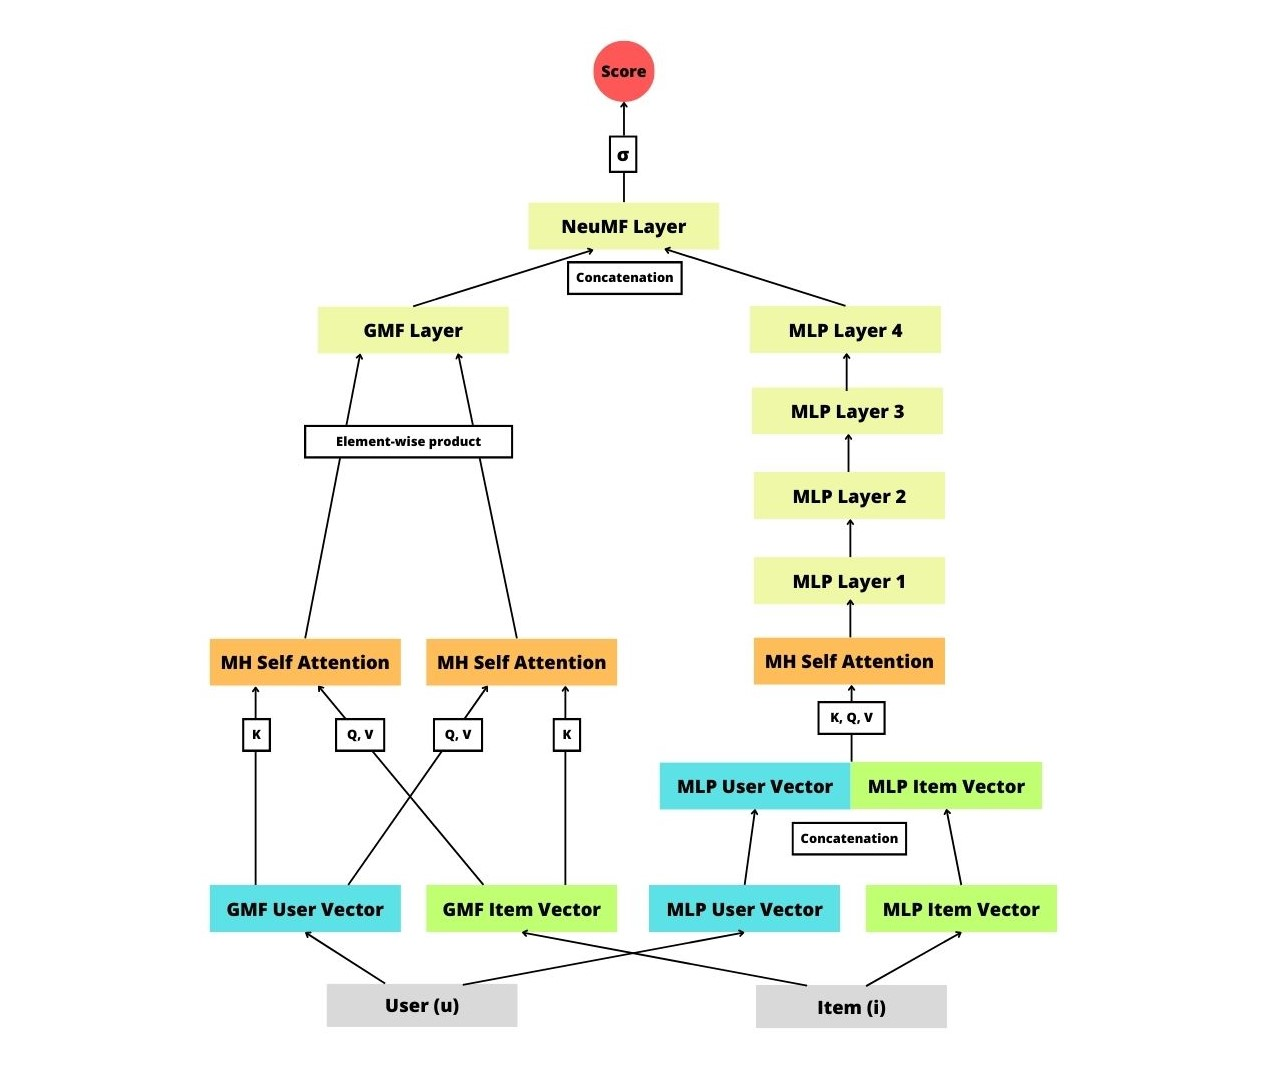

# Description
In this architecture, I made modifications to the NeuMF class by incorporating multihead attention into both the MLP embeddings and GMF embeddings.

For the GMF embeddings, I introduced two multihead attention blocks. In the first block, I used the key of the user embedding and the query and value of the item embedding. In the second block, I utilized the query and value of the user embedding, while the key was derived from the item embedding. This approach enhances the understanding of the relationships between users and items.

Moving on to the MLP part of the architecture, I inserted a multihead attention block after concatenating the two embedding layers. Putting together the embeddings will allow the attention mechanism to find new types of features.

The subsequent sections of the architecture remain unaltered.

In [ ]:
class NeuMF_Turchetta(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(NeuMF_Turchetta, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num
        self.layers = args.layers

        self.gmf_user_embedding = nn.Embedding(self.num_users, self.factor_num)
        self.gmf_item_embedding = nn.Embedding(self.num_items, self.factor_num)
        self.mlp_user_embedding = nn.Embedding(self.num_users, self.factor_num)
        self.mlp_item_embedding = nn.Embedding(self.num_items, self.factor_num)
        
        mlp_layer_sizes = self.layers
        self.mlp_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(mlp_layer_sizes[:-1], mlp_layer_sizes[1:])):
            self.mlp_layers.append(nn.Linear(in_size, out_size))

        self.output_layer = nn.Linear(in_features=mlp_layer_sizes[-1] + self.factor_num, out_features=1)
        self.logistic = torch.sigmoid

    def forward(self, user_indices, item_indices):
        # Matrix factorization branch
        gmf_user_embedding = self.gmf_user_embedding(user_indices)
        gmf_item_embedding = self.gmf_item_embedding(item_indices)
        gmf_user_attention= self_attention2(gmf_user_embedding, gmf_item_embedding)
        gmf_item_attention= self_attention2(gmf_item_embedding, gmf_user_embedding)
        gmf_user_attention=gmf_user_attention.squeeze(dim=1)
        gmf_item_attention=gmf_item_attention.squeeze(dim=1)
      
        gmf_output = torch.mul(gmf_user_attention, gmf_item_attention) # GMF layer

        
        # Multilayer perceptron branch
        mlp_user_embedding = self.mlp_user_embedding(user_indices)
        mlp_item_embedding = self.mlp_item_embedding(item_indices)

   
        mlp_output = torch.cat([mlp_user_embedding,mlp_item_embedding], dim=-1) 
        mlp_output=self_attention(mlp_output)
        mlp_output=mlp_output.squeeze(dim=1)
        for idx, _ in enumerate(range(len(self.mlp_layers))):
            mlp_output = self.mlp_layers[idx](mlp_output)
            mlp_output = nn.ReLU()(mlp_output)
        
        # Concatenate GMF and MLP outputs and pass through final layer
        concatenated = torch.cat([gmf_output, mlp_output], dim=1)
        logits = self.output_layer(concatenated)
        rating = self.logistic(logits)
        return rating.squeeze()

# Arredondo's Architecture:

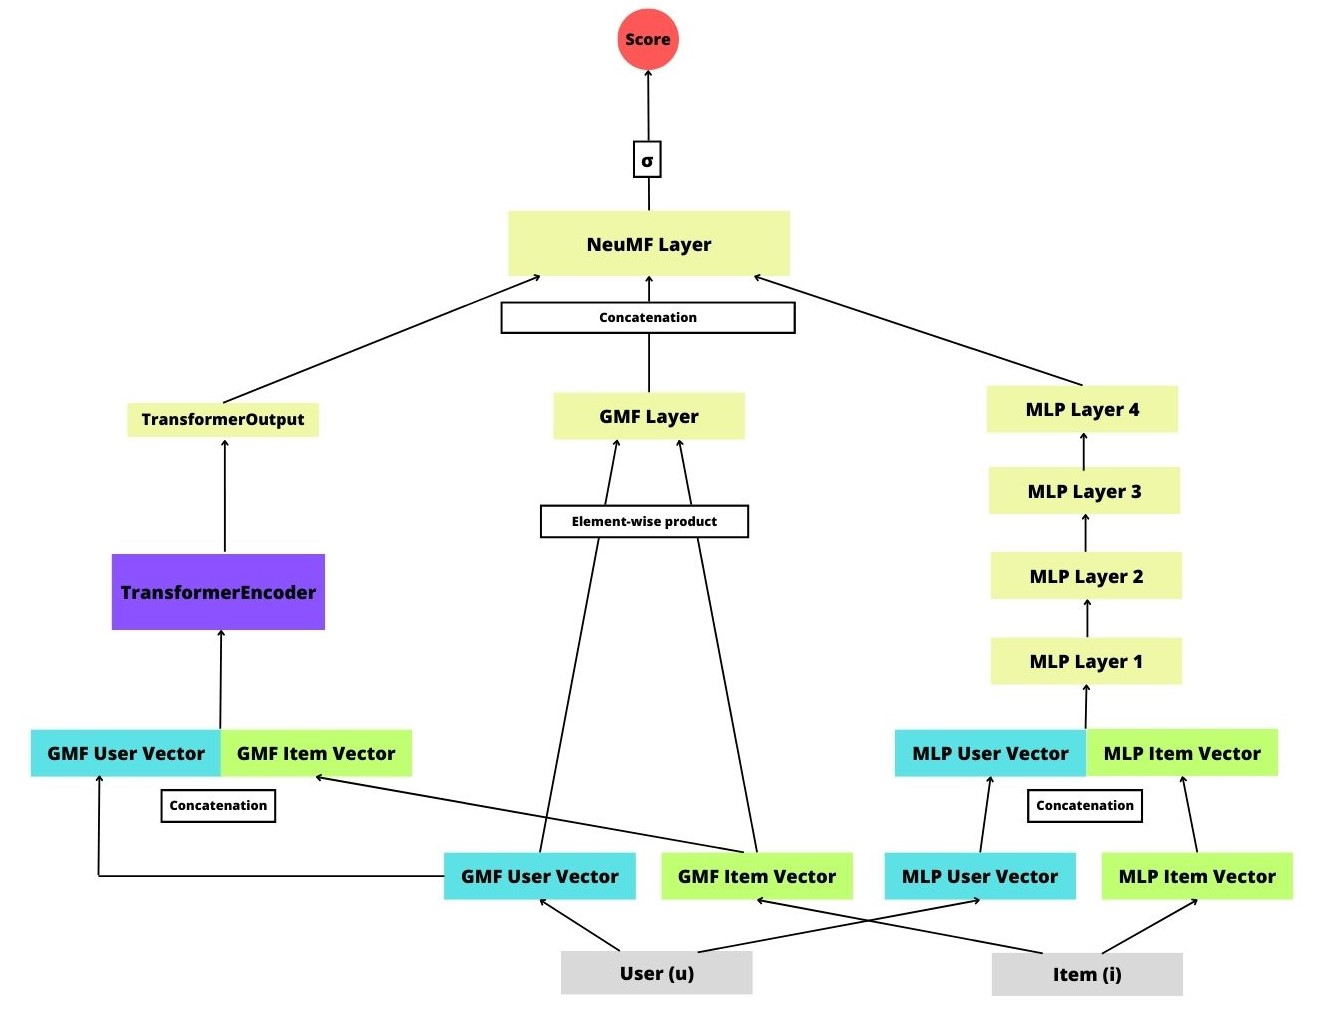

# Description:

As shown in the diagram, an additional parallel branch, called the Transformer branch, has been added to the original NeuMF model. The purpose of the Transformer branch is to capture complex relationships and dependencies between user-item interactions using self-attention mechanisms. Specifically, the embeddings of the user and item from the GMF branch are concatenated, resulting in a combined input tensor. This tensor is then passed through a TransformerEncoder, which consists of a stack of N encoder layers (in this case, N=2). The TransformerEncoder applies multiple layers of self-attention and feed-forward transformations to process the input and capture the relationships between different elements in the sequence. Finally, the output tensor from the Transformer branch is concatenated with the outputs from the GMF and MLP layers. The concatenated tensor is then passed through a sigmoid function to obtain the final score.

In [ ]:
class NeuMF_Arredondo(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(NeuMF_Arredondo, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num
        self.layers = args.layers
        self.hidden_dim = args.hidden_dim

        self.gmf_user_embedding = nn.Embedding(self.num_users, self.factor_num)
        self.gmf_item_embedding = nn.Embedding(self.num_items, self.factor_num)
        self.mlp_user_embedding = nn.Embedding(self.num_users, self.factor_num)
        self.mlp_item_embedding = nn.Embedding(self.num_items, self.factor_num)

        mlp_layer_sizes = self.layers
        self.mlp_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(mlp_layer_sizes[:-1], mlp_layer_sizes[1:])):
            self.mlp_layers.append(nn.Linear(in_size, out_size))

        self.transformer_layer = TransformerEncoderLayer(d_model=self.hidden_dim, nhead=8)
        self.transformer_encoder = TransformerEncoder(self.transformer_layer, num_layers=2)

        self.output_layer = nn.Linear(in_features=mlp_layer_sizes[-1] + self.hidden_dim + self.factor_num , out_features=1)
        self.logistic = torch.sigmoid

    def forward(self, user_indices, item_indices):
        # Matrix factorization branch
        gmf_user_embedding = self.gmf_user_embedding(user_indices)
        gmf_item_embedding = self.gmf_item_embedding(item_indices)
        gmf_output = torch.mul(gmf_user_embedding, gmf_item_embedding) 

        # Multilayer perceptron branch
        mlp_user_embedding = self.mlp_user_embedding(user_indices)
        mlp_item_embedding = self.mlp_item_embedding(item_indices)
        mlp_output = torch.cat([mlp_user_embedding, mlp_item_embedding], dim=1)
        for idx, _ in enumerate(range(len(self.mlp_layers))):
            mlp_output = self.mlp_layers[idx](mlp_output)
            mlp_output = nn.ReLU()(mlp_output)

        # Transformer Branch
        transformer_input = torch.cat([gmf_user_embedding, gmf_item_embedding], dim=1)  
        transformer_input = transformer_input.unsqueeze(0) 
        transformer_output = self.transformer_encoder(transformer_input) 
        transformer_output = transformer_output.squeeze() 
        
        # Concatenate GMF, MLP and Transformer Output and pass through a final layer
        concatenated = torch.cat([gmf_output, mlp_output, transformer_output], dim=1) 
        logits = self.output_layer(concatenated)
        rating = self.logistic(logits)
        return rating.squeeze()